In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from pmdarima import auto_arima

## Model 0 - ARIMA

In [2]:
# https://github.com/das-amlan/Stock-Price-Forecasting/blob/main/Stock_price_forecasting.ipynb

In [3]:
df_nasdaq = pd.read_csv('df_nasdaq.csv')
df_sp500 = pd.read_csv('df_sp500.csv')
df_dji = pd.read_csv('df_dji.csv')

In [4]:
df_close = pd.DataFrame({
    'Date': df_nasdaq['Date'],
    'nasdaq': df_nasdaq['Close'],
    'sp500': df_sp500['Close'],
    'dji': df_dji['Close']
})

df_close['Date'] = pd.to_datetime(df_close['Date'])
df_close.set_index('Date', inplace=True)

train_size = int(len(df_close) * 0.8)
df_train_close = df_close[:train_size]
df_test_close = df_close[train_size:]

print(df_close.head())
print(f"Shape of training set: {df_train_close.shape}")
print(f"Shape of testing set: {df_test_close.shape}")

                 nasdaq        sp500           dji
Date                                              
2019-03-14  7630.910156  2808.479980  25709.939453
2019-03-15  7688.529785  2822.479980  25848.869141
2019-03-18  7714.479980  2832.939941  25914.099609
2019-03-19  7723.950195  2832.570068  25887.380859
2019-03-20  7728.970215  2824.229980  25745.669922
Shape of training set: (1097, 3)
Shape of testing set: (275, 3)


### Seasonal Decomposition

<Figure size 640x480 with 0 Axes>

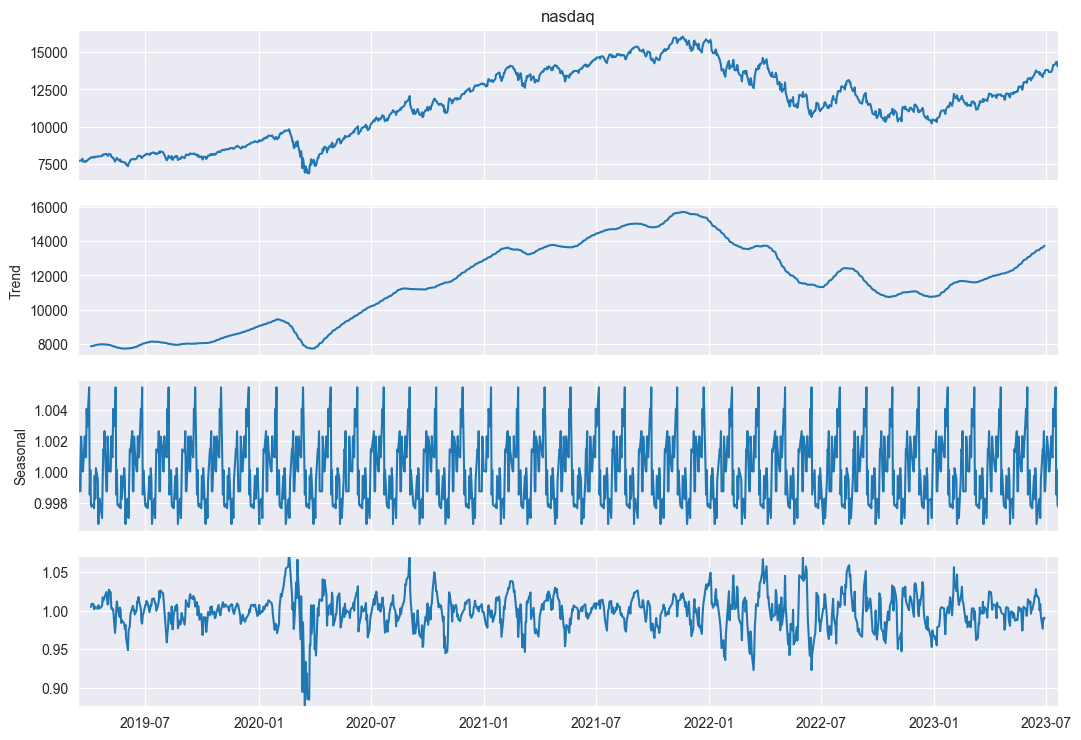

<Figure size 640x480 with 0 Axes>

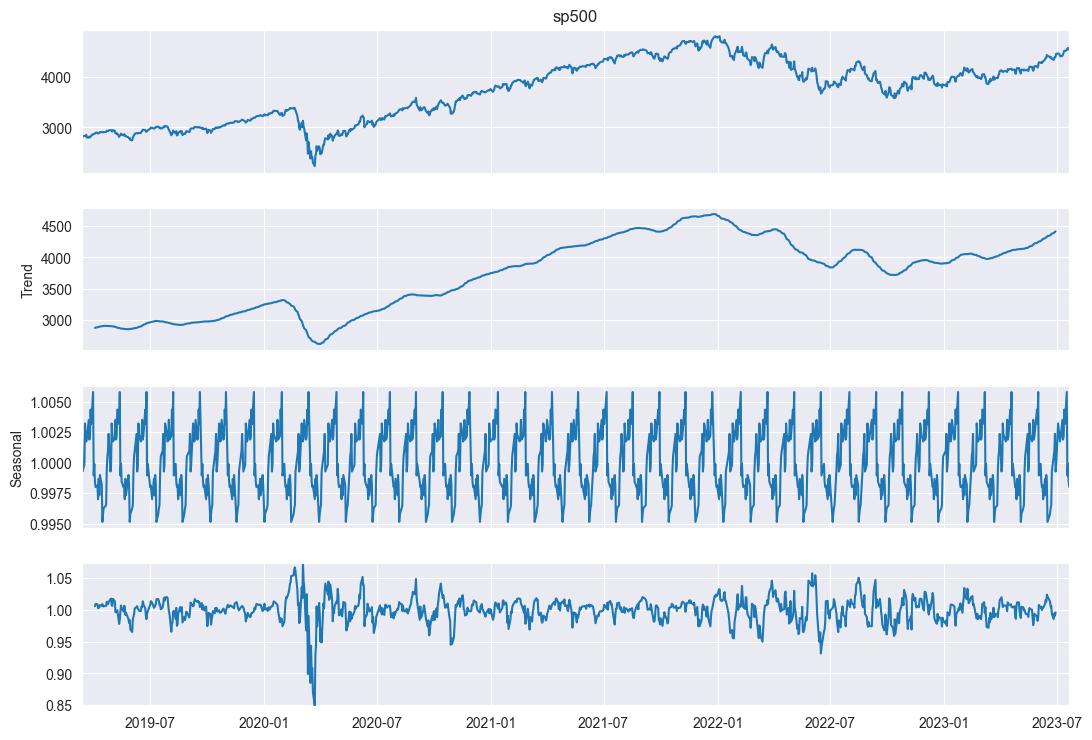

<Figure size 640x480 with 0 Axes>

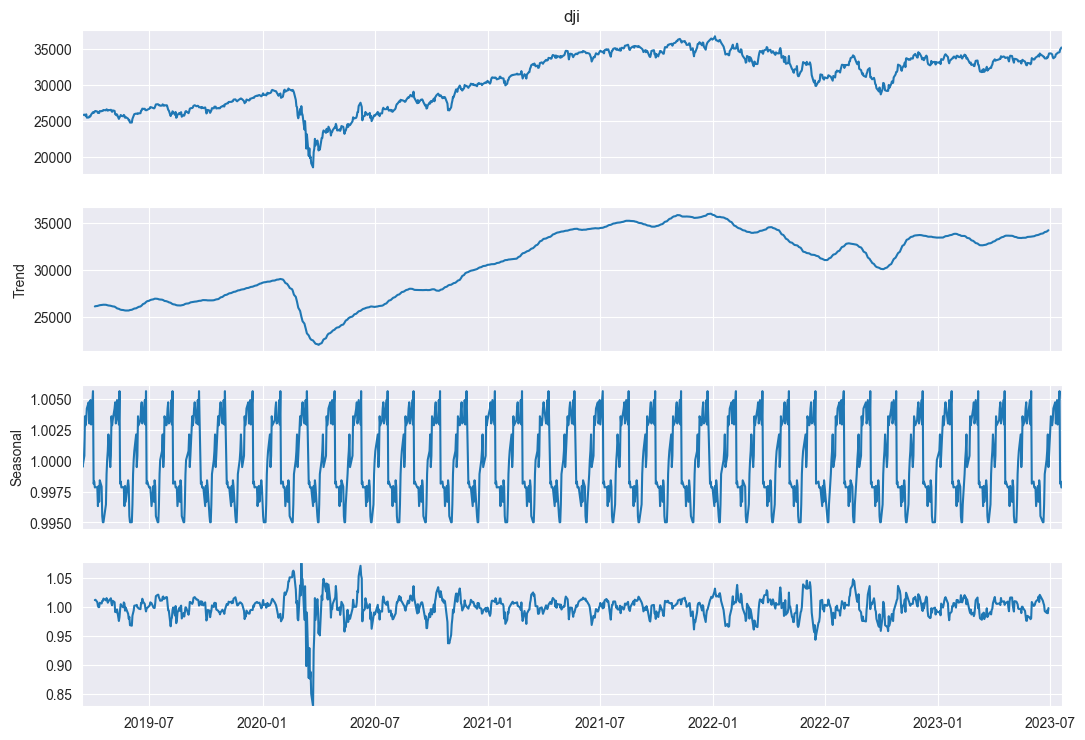

In [5]:
stock_name = ['nasdaq', 'sp500', 'dji']
for i in stock_name:
    result = seasonal_decompose(df_train_close[i], model='multiplicative', period=30)
    fig = plt.figure()  
    fig = result.plot()  
    plt.title(i) 
    fig.set_size_inches(12, 8)
    
    # Change the y-axis of residual plot
    residual_ax = fig.axes[3]
    residual_ax.clear()
    residual_ax.plot(result.resid.index, result.resid)
    residual_ax.set_ylim(result.resid.min(), result.resid.max())
    
plt.show()

### ADF test - Check Stationary

In [6]:
for i in stock_name:
    print([i])
    result = adfuller(df_train_close[i], autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]["5%"]:
        print ("Reject Null Hypothesis. So, Time Series is Stationary")
    else:
        print ("Failed to reject Null Hypothesis. So, Time Series is Not-Stationary")
    print("\n")

['nasdaq']
ADF Statistic: -1.488997
p-value: 0.538947
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary


['sp500']
ADF Statistic: -1.403012
p-value: 0.580831
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary


['dji']
ADF Statistic: -1.729701
p-value: 0.415878
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary




### Normality Test

In [7]:
for i in stock_name:
    print([i])
    stat, p = normaltest(df_train_close[i])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    alpha = 0.05
    if p > alpha:
        print('Data is normally distributed (fail to reject H0)')
    else:
        print('Data is not normally distributed(reject H0)')
    print('\n')

['nasdaq']
Statistics=450.441, p=0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)


['sp500']
Statistics=716.444, p=0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)


['dji']
Statistics=145.980, p=0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)




### log Transformation

In [8]:
df_train_close_log = np.log(df_train_close / df_train_close.shift(1))
df_train_close_log = df_train_close_log.dropna()
print(df_train_close_log.head())

              nasdaq     sp500       dji
Date                                    
2019-03-15  0.007522  0.004973  0.005389
2019-03-18  0.003369  0.003699  0.002520
2019-03-19  0.001227 -0.000131 -0.001032
2019-03-20  0.000650 -0.002949 -0.005489
2019-03-21  0.014131  0.010794  0.008387


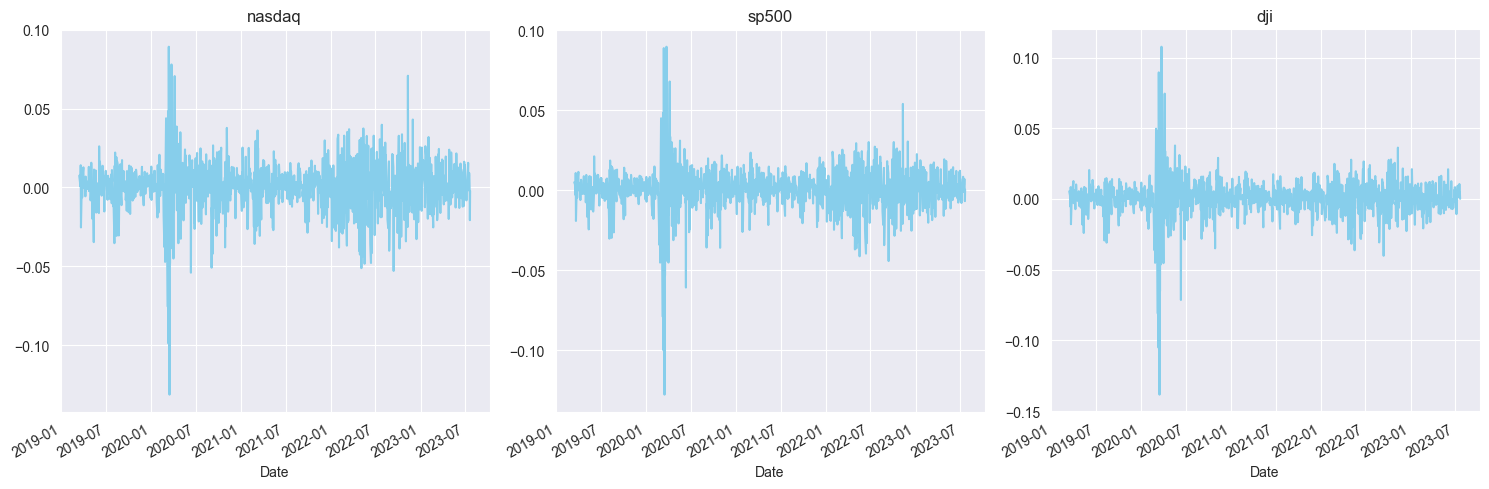

In [9]:
num_columns = len(df_train_close_log.columns)
fig, axes = plt.subplots(1, num_columns, figsize=(num_columns * 5, 5))

for i, column in enumerate(df_train_close_log.columns):
    df_train_close_log[column].plot(ax=axes[i], color='skyblue')
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

### ADF test and Normality test for log-transformed data

In [10]:
for i in stock_name:
    print([i])
    result = adfuller(df_train_close_log[i], autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]["5%"]:
        print ("Reject Null Hypothesis. So, Time Series is Stationary")
    else:
        print ("Failed to reject Null Hypothesis. So, Time Series is Not-Stationary")
    print("\n")

['nasdaq']
ADF Statistic: -10.065512
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Reject Null Hypothesis. So, Time Series is Stationary


['sp500']
ADF Statistic: -9.761586
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Reject Null Hypothesis. So, Time Series is Stationary


['dji']
ADF Statistic: -9.878980
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Reject Null Hypothesis. So, Time Series is Stationary




In [11]:
for i in stock_name:
    print([i])
    stat, p = normaltest(df_train_close_log[i])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    alpha = 0.05
    if p > alpha:
        print('Data is normally distributed (fail to reject H0)')
    else:
        print('Data is not normally distributed(reject H0)')
    print('\n')

['nasdaq']
Statistics=227.458, p=0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)


['sp500']
Statistics=334.136, p=0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)


['dji']
Statistics=410.564, p=0.000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)




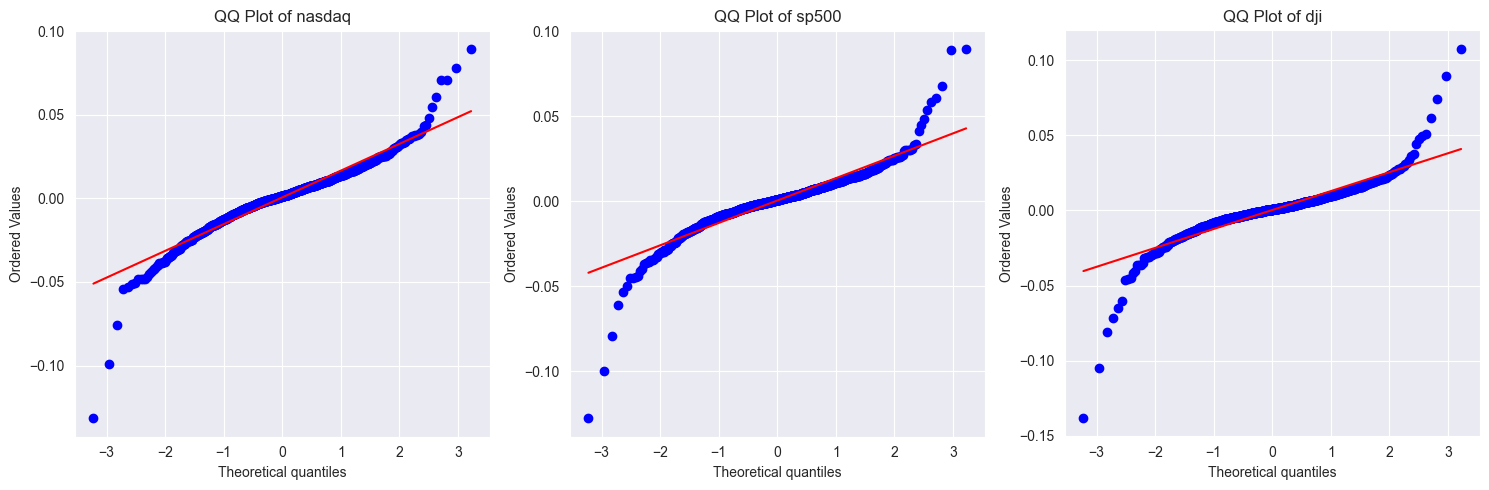

In [13]:
num_columns = len(df_train_close_log.columns)
fig, axes = plt.subplots(1, num_columns, figsize=(num_columns * 5, 5))

for i, column in enumerate(df_train_close_log.columns):
    stats.probplot(df_train_close_log[column].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'QQ Plot of {column}')

plt.tight_layout()
plt.show()

In [15]:
# Dateset are not normally distributed.
# Maybe can use Generalized Additive Models (GAM) to fit.

### Fit ARIMA model

In [27]:
arima_models = {}

for stock in stock_name:
    print(f"Fitting ARIMA model for {stock}...")
    model = auto_arima(df_train_close[stock], seasonal=False, trace=True, stepwise=True)
    arima_models[stock] = model
    print(f"Best ARIMA model for {stock}: {model.summary()}\n")

Fitting ARIMA model for nasdaq...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14460.390, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14494.369, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14487.054, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14487.629, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14493.526, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14489.669, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14485.676, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14492.252, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14492.037, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14487.795, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14490.024, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14490.064, Time=0.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=14462.652, Time=1.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=14490.896,

### ARIMA - Prediction

In [28]:
num_prediction = len(df_test_close)
prediction = {}

for stock in stock_name:
    prediction[stock] = arima_models[stock].predict(n_periods=num_prediction)

C:\Users\83995\.conda\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\83995\.conda\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\83995\.conda\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\83995\.conda\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will r

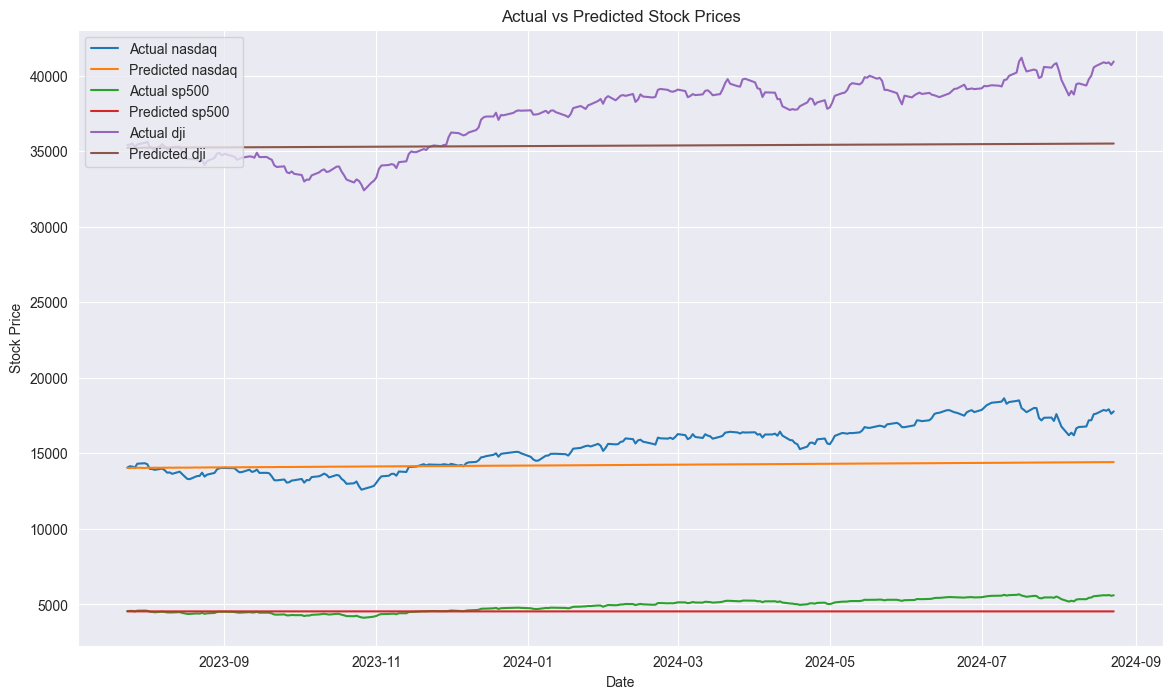

In [29]:
plt.figure(figsize=(14, 8))

for stock in stock_name:
    plt.plot(df_test_close.index, df_test_close[stock], label=f'Actual {stock}')
    plt.plot(df_test_close.index, prediction[stock], label=f'Predicted {stock}')

plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### ARIMA - Error Metrics

In [30]:
def calculate_error_metrics(y_test, y_pred):

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')

    return

In [31]:
for stock in stock_name:
    print(f"\nError Metrics for {stock}:")
    y_test = df_test_close[stock].values  # Replace with the actual test data
    y_pred = prediction[stock]  # Replace with the predicted data
    calculate_error_metrics(y_test, y_pred)


Error Metrics for nasdaq:
Mean Squared Error (MSE): 3527955.643678626
Mean Absolute Error (MAE): 1507.1185421304226
R-squared (R²): -0.4558706700832711

Error Metrics for sp500:
Mean Squared Error (MSE): 315970.81588075723
Mean Absolute Error (MAE): 455.29957856758415
R-squared (R²): -0.7483491382286478

Error Metrics for dji:
Mean Squared Error (MSE): 8662408.821543103
Mean Absolute Error (MAE): 2552.398611657053
R-squared (R²): -0.645842355552255
